Data taken from:
https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&visualizationUrl=U2FsdGVkX1%2FbjbyhYTL7kBbfp9HARO8fV%2BXJRCGHD1NFLqsZu5c9jLN3f6Sd4V2ytYWRNj6xtk46tqjWsOsIbUl4pExcrmVfxglfITLscU3DbWsLYpdOCReGfImyuAK2&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE

Area of interest: Gulf of Mexico, SLC(complex images), IW, VV+VH
## Skapiraj sta su ove oznake 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from pathlib import Path

In [2]:

extract_dir = "S1A_SAFE_extracted"
measurement_path = os.path.join(extract_dir, 
                                "S1A_IW_SLC__1SDV_20251115T002636_20251115T002703_061881_07BCC0_592D.SAFE", 
                                "measurement")

tiff_files = []
for root, dirs, files in os.walk(measurement_path):
    tiff_files.extend([os.path.join(root, f) for f in files if f.endswith('.tiff')])

print(f"Found {len(tiff_files)} TIFF files:")
for i, tiff in enumerate(tiff_files):
    filename = os.path.basename(tiff)
    print(f"  {i}: {filename}")

Found 6 TIFF files:
  0: s1a-iw1-slc-vh-20251115t002637-20251115t002702-061881-07bcc0-001.tiff
  1: s1a-iw1-slc-vv-20251115t002637-20251115t002702-061881-07bcc0-004.tiff
  2: s1a-iw2-slc-vh-20251115t002638-20251115t002703-061881-07bcc0-002.tiff
  3: s1a-iw2-slc-vv-20251115t002638-20251115t002703-061881-07bcc0-005.tiff
  4: s1a-iw3-slc-vh-20251115t002636-20251115t002701-061881-07bcc0-003.tiff
  5: s1a-iw3-slc-vv-20251115t002636-20251115t002701-061881-07bcc0-006.tiff


In [4]:
# Load one TIFF file (VV polarization)
selected_file = tiff_files[0] 
print(f"Loading: {os.path.basename(selected_file)}")

with rasterio.open(selected_file) as src:
    print(f"\nImage Info:")
    print(f"  Dimensions: {src.width} x {src.height}")
    print(f"  Data type: {src.dtypes[0]}")
    print(f"  Number of bands: {src.count}")
    print(f"  CRS: {src.crs}")
    

    complex_data = src.read(1)
    
print(f"\nData shape: {complex_data.shape}")
print(f"Data type: {complex_data.dtype}")


Loading: s1a-iw1-slc-vh-20251115t002637-20251115t002702-061881-07bcc0-001.tiff

Image Info:
  Dimensions: 21490 x 13428
  Data type: complex_int16
  Number of bands: 1
  CRS: None

Data shape: (13428, 21490)
Data type: complex64

Data shape: (13428, 21490)
Data type: complex64


In [64]:
# Full image is too big to work with so we will use only part of it
roi_size = 256
center_x = complex_data.shape[1] // 2
center_y = complex_data.shape[0] // 2

start_x = center_x + roi_size*2 + roi_size //2
start_y = center_y + roi_size*3

sar_roi = complex_data[start_y:start_y+roi_size, start_x:start_x+roi_size]


print(f"ROI shape: {sar_roi.shape}")
print(f"ROI dtype: {sar_roi.dtype}")

ROI shape: (256, 256)
ROI dtype: complex64


In [65]:
# intensity
intensity = np.abs(sar_roi)**2

# log intensity for visualization
intensity_db = 10 * np.log10(intensity + 1e-10) 

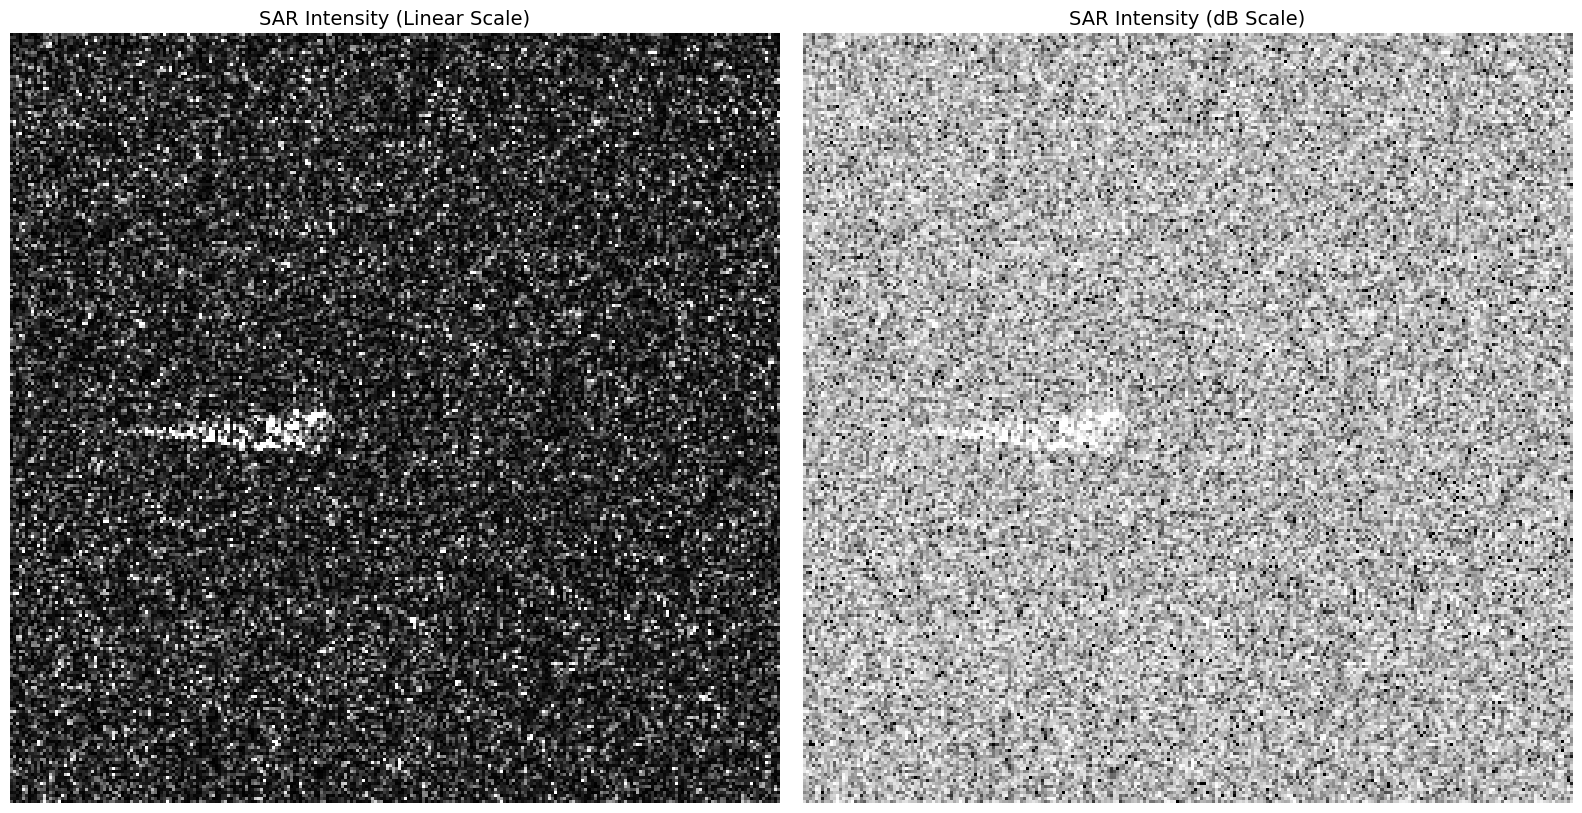

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Linear scale
axes[0].imshow(intensity, cmap='gray', vmin=np.percentile(intensity, 1), 
               vmax=np.percentile(intensity, 99))
axes[0].set_title('SAR Intensity (Linear Scale)', fontsize=14)
axes[0].axis('off')

# dB scale
axes[1].imshow(intensity_db, cmap='gray', vmin=np.percentile(intensity_db, 1), 
               vmax=np.percentile(intensity_db, 99))
axes[1].set_title('SAR Intensity (dB Scale)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Now we will implement the algorithm explained in the paper "OPTIMAL TARGET DETECTION USING ONE CHANNEL SAR COMPLEX IMAGERY : APPLICATION TO SHIP DETECTION"

In [109]:
N1 = 11 # Test area, where we expect to find a ship 
# A ship might be larger than the area of 9 (3x3) pixels,
# but we will fill in the missing pixels at the end
N2 = 21 # Background reference area
paf = 10e-5  # Probability of false alarm
padded_image = np.pad(intensity, N2, mode='constant', constant_values=0) 

In [110]:
from scipy.special import hyp2f1, beta as beta_func
from scipy.optimize import brentq

def compute_threshold_lopes1998(N1, N2, P_FA):
    """
    
    Equation (6): P_FA = 1 - (1/B(N1,N2)) * (t^N1 / N1) * 2F1(N1, 1-N2; 1+N1; t)
    where t = N1*T / (N2 + N1*T)
    
    We solve for T such that the CDF equals (1 - P_FA).
    """
    
    def pfa_from_threshold(T):
        if T <= 0:
            return 1.0  # All pixels detected
        
        # Transform: t = N1*T / (N2 + N1*T)
        t = (N1 * T) / (N2 + N1 * T)
        
        if t >= 1.0:
            return 0.0  # No detections
        
        try:
            # Beta function B(N1, N2) = Γ(N1)Γ(N2) / Γ(N1+N2)
            B_val = beta_func(N1, N2)
            
            # Hypergeometric function 2F1(N1, 1-N2; 1+N1; t)
            hyp_val = hyp2f1(N1, 1 - N2, 1 + N1, t)
            
            cdf = (1.0 / B_val) * (t**N1 / N1) * hyp_val
            
            pfa_computed = 1.0 - cdf
            
            return pfa_computed
            
        except Exception as e:
            print(f"Warning: Numerical issue in hypergeometric function: {e}")
            return None
    
    def equation_to_solve(T):
        pfa_val = pfa_from_threshold(T)
        if pfa_val is None:
            return float('inf')
        return pfa_val - P_FA
    
    # Solve for threshold T
    try:
        # Search in reasonable range [0.1, 20]
        T_solution = brentq(equation_to_solve, 0.1, 20.0, maxiter=100) # Finds root
        return T_solution
        
    except ValueError as e:
        print(f"Warning: Root finding failed: {e}")
        print("Using empirical approximation instead.")
        # Fallback to empirical formula
        T_empirical = 1.5 - 0.5 * np.log10(P_FA)
        return max(1.5, min(T_empirical, 10.0))

# Compute threshold for your parameters
T_computed = compute_threshold_lopes1998(N1**2, N2**2 - N1**2, paf)
print(f"\n✓ Computed threshold: T = {T_computed:.4f}")



✓ Computed threshold: T = 1.4696


In [111]:
binary_detection_map = np.zeros_like(padded_image, dtype=np.uint8)
for i in range(N2, padded_image.shape[0] - N2):
    for j in range(N2, padded_image.shape[1] - N2):
        test_area = padded_image[i - N1:i + N1 + 1, j - N1:j + N1 + 1]
        test_mean = np.mean(test_area)
        local_mean = (np.sum(padded_image[i - N2:i + N2 + 1, j - N2:j + N2 + 1]) - 
                      np.sum(test_area)) / ( (2*N2 + 1)**2 - (2*N1 + 1)**2 )
        if local_mean == 0:
            binary_detection_map[i, j] = 0
        else:
            r = test_mean / local_mean
            if r > T_computed:
                binary_detection_map[i, j] = 1
            else:
                binary_detection_map[i, j] = 0
# Remove padding to match original image size
binary_detection_map = binary_detection_map[N2:-N2, N2:-N2]

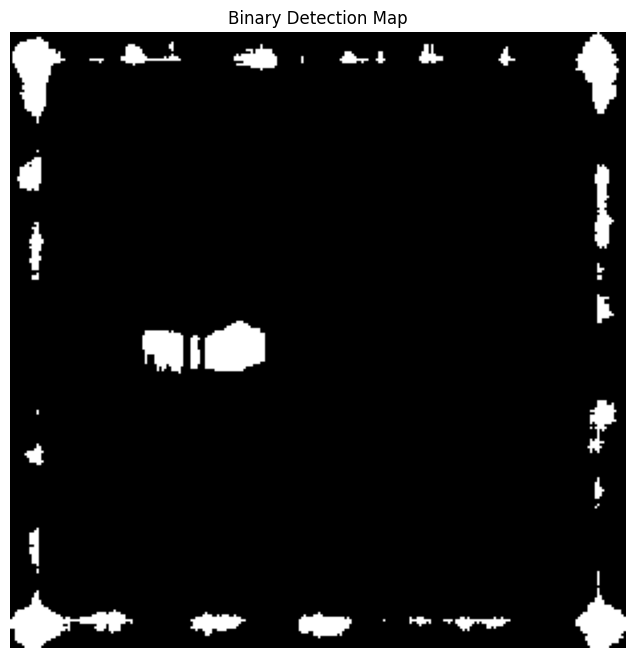

In [112]:
plt.figure(figsize=(8, 8))
plt.imshow(binary_detection_map, cmap='gray')
plt.title('Binary Detection Map')
plt.axis('off')
plt.show()

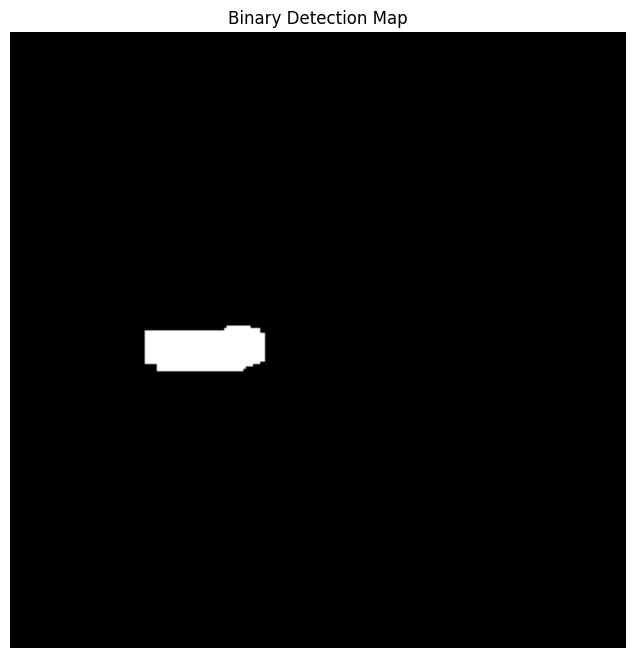

In [113]:
from scipy.ndimage import binary_closing, binary_opening
# Morphological operations to clean up the detection map
cleaned_map = binary_opening(binary_closing(binary_detection_map, structure=np.ones((20,20))), structure=np.ones((9,9)))
plt.figure(figsize=(8, 8))
plt.imshow(cleaned_map, cmap='gray')
plt.title('Binary Detection Map')
plt.axis('off')
plt.show()

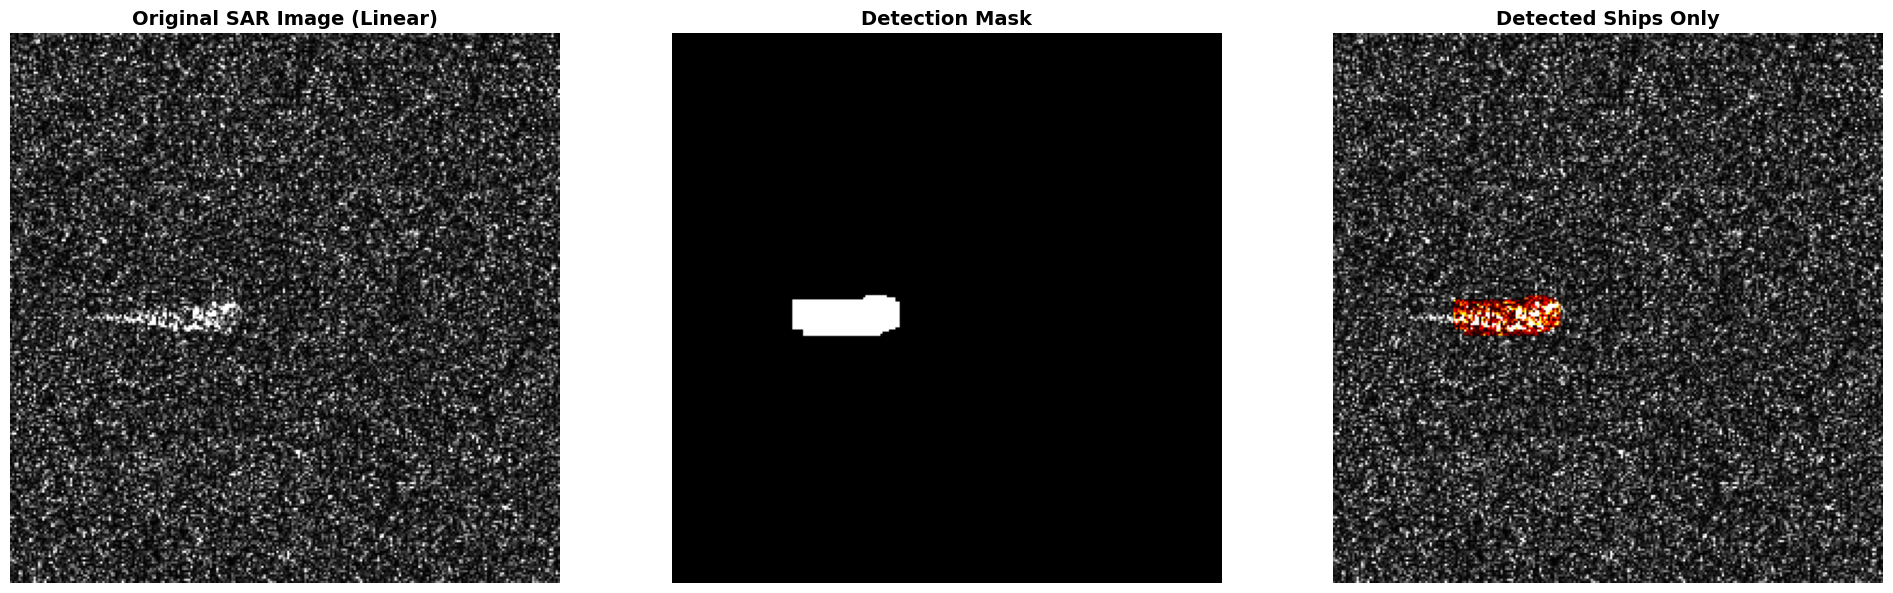

In [114]:

masked_intensity = intensity.copy()
masked_intensity[cleaned_map == 0] = np.nan 

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original SAR image (linear scale)
axes[0].imshow(intensity, cmap='gray', vmin=np.percentile(intensity, 1), 
               vmax=np.percentile(intensity, 99))
axes[0].set_title('Original SAR Image (Linear)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Binary mask
axes[1].imshow(cleaned_map, cmap='gray')
axes[1].set_title('Detection Mask', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Masked intensity (only detected regions) - linear scale
axes[2].imshow(intensity, cmap='gray', vmin=np.percentile(intensity, 1), 
               vmax=np.percentile(intensity, 99))
axes[2].imshow(masked_intensity, cmap='hot', vmin=np.percentile(intensity, 1), 
               vmax=np.percentile(intensity, 99))
axes[2].set_title('Detected Ships Only', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()